# Анализ данных отдела продаж

## Подготовка необходимых данных

In [1]:
# импорт необходимых для дальнейшей работы библиотек 

import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from urllib.parse import urlencode
from datetime import timedelta
from matplotlib.ticker import NullFormatter, MultipleLocator

%matplotlib inline

In [2]:
# глобальные параметры для визуализации

sns.set(
    rc = {
        'figure.figsize' : (15,8),
        'axes.titlesize' : 16,
        'axes.labelsize' : 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'axes.titlepad'  : 30,
    },
    font_scale = 1.3,
    
)
cmap = sns.cubehelix_palette(start=0, light=0.9, as_cmap=True)

In [4]:
# функция, для дополнительной стилизации дата-фреймов

def make_custom_style (styler, df_caption, max_color = 'mediumpurple'):
    """
    Функция устанавливает пользовательские стили на дата-фреймы
    
    Параметры:
    ---------
    df_caption:
        Наименование таблицы/дата-фрейма
    max_color:
        Цвет ячеек с максимальными значениями в таблице
        
    Возвращаемое значение:
    ---------------------
        Styler
    """
    styler.set_caption(df_caption)
    styler.background_gradient(axis=None, vmin=1, vmax=5, cmap='YlGnBu')
    styler.highlight_max(color='mediumpurple', axis=1)
    styler.set_precision(0)
    
    return styler

In [5]:
# функция для выбора ссылок для чтения данных

def get_download_urls (api_urls: dict, local_urls: dict) -> dict:
    """
    Функция, которая возвращает ссылки для подключения к данным 
    в зависимости от того, возникает ли ошибка подключения к API
    
    Параметры:
    ---------
    api_urls: dict
        Ссылки для подключения к данным через Яндекс Диск API
    local_urls: dict
        Ссылки для подключения к данным локально
        
    Возвращаемое значение:
    ----------------------
        Словарь с ссылками на подключение к данным 
    """
    try:
        customers_url = requests.get(api_urls['customers']).json()['href']
        orders_url    = requests.get(api_urls['orders']).json()['href']
        items_url     = requests.get(api_urls['order_items']).json()['href']
    except:
        customers_url = local_urls['customers']
        orders_url    = local_urls['orders']
        items_url     = local_urls['order_items']
        
    return {
        'customers' : customers_url,
        'orders'    : orders_url,
        'items'     : items_url
    } 

### Устранение проблемы при подключении к данным

При загрузке данных через Яндекс API время от времени (при потере соединения) заново загрузить файлы с диска не удается, так как есть ограничение по количеству подключений. По этой причине будем использовать 2 варианта подключения к файлам для дальнейшей работы и выбор каждого будет происходить в зависимости от того, возникает ли ошибка при подключении через Яндекс Диск API или нет: 

- Яндекс Диск API
- Локально загруженные файлы с данными

In [8]:
# подготовка ссылок для загрузки данных

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# ссылки для загрузки данных через Яндекс Диск API

download_urls_yandex_api = {
    'customers'   : base_url + urlencode(dict(public_key='https://disk.yandex.ru/d/QXrVDUoQvFhIcg')),
    'orders'      : base_url + urlencode(dict(public_key='https://disk.yandex.ru/d/0zWmh1bYP6REbw')),
    'order_items' : base_url + urlencode(dict(public_key='https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'))
}
# пути для загрузки локальных данных

download_urls_local = {
    'customers'    : '/mnt/HC_Volume_18315164/home-jupyter/jupyter-alekse-popov/first_project/olist_customers_dataset.csv',
    'orders'      : '/mnt/HC_Volume_18315164/home-jupyter/jupyter-alekse-popov/first_project/olist_orders_dataset.csv',
    'order_items' : '/mnt/HC_Volume_18315164/home-jupyter/jupyter-alekse-popov/first_project/olist_order_items_dataset.csv'
}

# результирующие ссылки для чтения данных

final_urls = get_download_urls(download_urls_yandex_api, download_urls_local)

In [9]:
# загрузка и предобработка данных о пользователях

customers_data = pd.read_csv(final_urls['customers'])

#### Данные о пользователях - таблица с уникальными идентификаторами пользователей
- Количество строк в дата-фрейме: **99441**
- Количество столбцов в дата-фрейме: **5**


| Название столбца         |  Что значит | Тип данных | Уникальность в таблице| Количество в дата-фрейме| NULL-значения|
|:------------- |:---------------| :-------------:| :--:| :--:|:--: |
| customer_id          | позаказный идентификатор пользователя          | String        | Да| 99441 | Нет|
| customer_unique_id         | уникальный идентификатор пользователя          | String        |Нет | 96096|Нет|
| customer_zip_code_prefix         | почтовый индекс пользователя          | Int64       | Нет|14994 |Нет|
| customer_city         | город доставки пользователя          | String        | Нет|4119 |Нет|
| customer_state         | штат доставки пользователя          | String        | Нет| 27|Нет|


In [10]:
# загрузка и предобработка данных о заказах

orders_data = pd.read_csv(
    final_urls['orders'],
    parse_dates = [
        'order_purchase_timestamp',
        'order_approved_at',
        'order_delivered_carrier_date',
        'order_delivered_customer_date',
        'order_estimated_delivery_date'
    ]
)

#### Данные о заказах - таблица с уникальными идентификаторами заказов
- Количество строк в дата-фрейме: **99441**
- Количество столбцов в дата-фрейме: **8**


| Название столбца         |  Что значит | Тип данных | Уникальность в таблице| Количество в дата-фрейме| NULL-значения|
|:------------- |:---------------| :-------------:| :--:| :--:|:--: |
| order_id          | уникальный идентификатор заказа (номер чека)         | String        | Да| 99441 | Нет|
| customer_id         | позаказный идентификатор пользователя          | String        |Да | 99441|Нет|
| order_status         | статус заказа          | String       | Нет|8 |Нет|
| order_purchase_timestamp         | время создания заказа          | Datetime64        | Нет|98875 |Нет|
| order_approved_at         | время подтверждения оплаты заказа          | Datetime64        | Нет| 90733|Да|
| order_delivered_carrier_date        | время передачи заказа в логистическую службу          | Datetime64        | Нет| 81018|Да|
| order_delivered_customer_date         | время доставки заказа          | Datetime64        | Нет| 95664|Да|
| order_estimated_delivery_date         | обещанная дата доставки         | Datetime64        | Нет| 459|Нет|

In [11]:
# загрузка и предобработка данных о товарах

items_data = pd.read_csv(
    final_urls['items'],
    parse_dates = ['shipping_limit_date']
)

#### Данные о товарах - таблица с товарами, которые присутствуют в заказах
- Количество строк в дата-фрейме: **112650**
- Количество столбцов в дата-фрейме: **7**


| Название столбца         |  Что значит | Тип данных | Уникальность в таблице| Количество в дата-фрейме| NULL-значения|
|:------------- |:---------------| :-------------:| :--:| :--:|:--: |
| order_id          | уникальный идентификатор заказа (номер чека)         | String        | Нет| 98666 | Нет|
| order_item_id         | идентификатор товара внутри одного заказа          | Int64        |Нет | 21|Нет|
| product_id         | id товара (аналог штрихкода)         | String       | Нет|32951 |Нет|
| seller_id         | id производителя товара          | String        | Нет|3095 |Нет|
| shipping_limit_date         | максимальная дата доставки продавцом для передачи заказа партнеру по логистике          | Datetime64        | Нет| 93318|Нет|
| price        | цена за единицу товара         | Float64        | Нет| 5968|Нет|
| freight_value         | вес товара          | Float64        | Нет| 6999|Нет|

### Количество пользователей с одним завершенным заказом ?

В качестве покупки в полученных данных будем подразумевать сделанный **завершенный** заказ. Статусы типа **created**, **approved** и **invoiced**, как правило выставляются до оплаты заказа, поэтому они не рассматриваются в качестве маркера для подтверждения покупки. Напротив, статусы **processing** и **shipped** выставляются после оплаты и означают активные этапы подготовке заказа к отправке пользователю. Однако в данном случае нельзя сказать, что пользователь уже приобрел этот товар, так как при процессе сборки заказа может выясниться, что необходимого товара нет на складе и заказ может быть отменен, а при отгрузке заказа со склада может случиться так, что заказ не дойдет до пользователя по какой-либо причине и это не будет считаться покупкой.

Принимая во внимание все вышеперечисленные утверждения, заказ может считаться завершенным, если **он был доставлен до пользователя (имеет статус - delivered)**, так как доставка до пользователя - это финальное действие в цепочке статусов, которые может принимать заказ. Соотвественно, необходимо найти **количество пользователей**, у которых есть **ровно один завершенный заказ** в нашем магазине. 

Данные по пользователям и заказам находятся в разных таблицах, следовательно необходимо будет объединить две таблицы друг с другом. Объединение таблиц будет происходить по customer_id, так как именно это является позаказным пользовательским id. В данном случае, это будет объединение вида **customers_data LEFT JOIN orders_data**, чтобы при отсутствии заказов у пользователя (отсутствие заказов данного пользователя в таблице orders), мы имели возможность также отслеживать пользователей без заказов (если такие имеются).

<img src="https://pyxis.nymag.com/v1/imgs/d6a/dc7/4a5001b7beea096457f480c8808572428b-09-roll-safe.rsquare.w400.jpg" alt="black guy memes" width="400" height="500">


In [12]:
# объединение данных о пользователях и заказах

orders_per_customer_data = customers_data.merge(right=orders_data, how='left', on='customer_id')     

In [24]:
# пользователи с 1 совершенным заказом

customers_with_one_order = orders_per_customer_data \
    .loc[orders_per_customer_data.order_status == 'delivered'] \
    .customer_unique_id \
    .value_counts() \
    .loc[lambda x: x == 1]

In [25]:
print('Количество пользователей с одним завершенным заказом: {}'.format(customers_with_one_order.count()))

Количество пользователей с одним завершенным заказом: 90557


Видно, что количество пользователей, которые совершили только один заказ, сильно превалирует над долей пользователей с более чем едичичным заказом в течение анализируемого периода

### Количество недоставленных по разным причинам заказов в месяц ?


Для начала нужно определить, что значит **заказ не доставляется**. Показателями доставки у нас выступают статусы заказа (order_status), поэтому нужно понять, какие именно статусы говорят нам о том, что заказ не был доставлен. Сразу отпадает статус **delivered** (по понятным причинам).

Статусы **created**, **approved**, **invoiced**, **processing**, **shipped** занимают промежуточную позицию при подготовке заказа: мы не можем считать заказ ни доставленным, ни недоставленным, так как данные статусы отображают операции, происходящие с заказом на пути к пользователю. По этой причине мы можем заказам с данными статусами присвоить категорию - **in process**.

Статус **canceled** однозначно означает, что заказ не будет доставлен, так как он был отменен. Соотвественно, в эту категорию и будем относить данные заказы. Статус **unavailable** не говорит нам о том, что именно происходит с заказом, однако такие заказы не попадают в категорию **delivered**, поэтому будет считать, что данные заказы тоже не были доставлены. Для упрощения восприятия результатов построим тепловую карту распределения недоставленных заказов в соответствии с их статусами. 

In [44]:
# количество недоставленных заказов в месяц в разбивке по статусам

non_delivered_orders = orders_data \
    .loc[~orders_data.order_status.isin(['delivered'])] \
    .assign(order_purchase_month = orders_data.order_purchase_timestamp.dt.strftime('%Y-%m')) \
    .pivot_table(
        values     = 'order_id', 
        index      = 'order_purchase_month',
        columns    = 'order_status',
        aggfunc    = 'nunique',
        fill_value = 0
    )

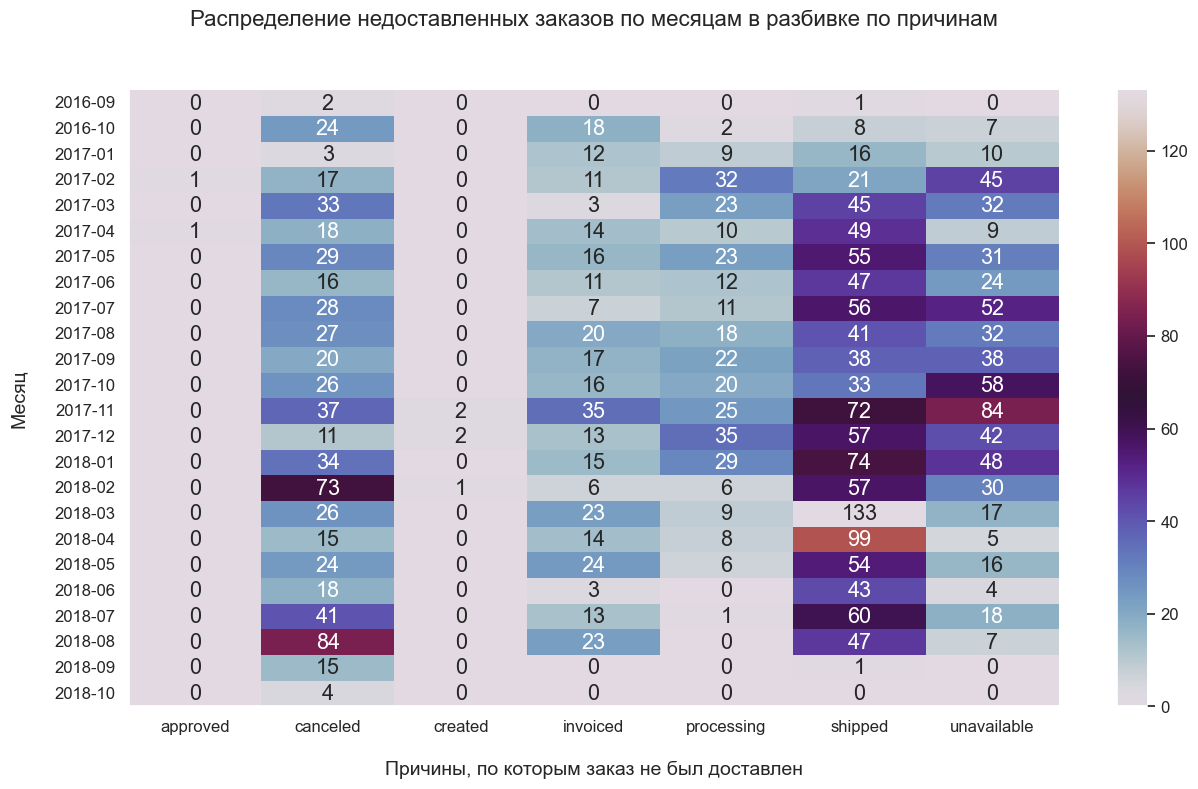

In [48]:
# визуализация недоставленных заказов в разбивке по месяцам по ВСЕМ (!) категориям

sns.heatmap(
    data  = non_delivered_orders,
    annot = True,
    cmap  = 'twilight',
    fmt   = '.0f'
) \
.set(
    title  = 'Распределение недоставленных заказов по месяцам в разбивке по причинам\n',
    ylabel = 'Месяц\n',
    xlabel = '\nПричины, по которым заказ не был доставлен'
)
sns.despine()

Например, видно, что количество заказов, имеющих статус **отгружен со склада (shipped)** превалируют над остальными в течение всего 2017 года и первой половины 2018 года из чего можно сделать вывод, что значительная часть неотправленных заказов может быть на совести курьерской службы. Также можно отметить, что на протяжении 2017 года было большое количество **недоступных** заказов и нужно более глубоко разобраться из-за чего это может быть.

### В какой день недели куплено больше всего товаров ?

В качестве даты покупки одной единицы товара будем использовать дату подтверждения оплаты заказа **order_approved_at**. Время создания заказа нам не подходит, так как заказ могли создать и не оплатить, а это явно не совершение покупки. Ранее мы руководствовались логикой, что купленным заказом считается тот заказ, который был доставлен до пользователя (имеет статус **delivered**). Однако здесь мы уберем ограничение на статусы заказа и под **покупкой** будем понимать решение клиента о том, **что он хочет сделать заказ и подтверждает свое намерение оплатой**

In [54]:
# расчет количества уникальных товаров

unique_items_count = items_data.product_id.nunique()
print('Общее количество уникальных товаров: {}'.format(unique_items_count))

Общее количество уникальных товаров: 32951


Перед тем, как рассчитывать объемы купленных товаров в зависимости от дня недели, нужно объединить все данные в один общий дата-фрейм

In [63]:
# объединение данных в единый дата-фрейм

total_data = customers_data \
    .merge(orders_data, how = 'left', on = 'customer_id') \
    .assign(order_approved_weekday = orders_data.order_approved_at.dt.day_name()) \
    .merge(items_data, how = 'inner', on = 'order_id') \
    [['product_id', 'order_approved_weekday']]

In [88]:
# расчет количества купленных товаров за день

products_per_weekday = total_data \
    .order_approved_weekday \
    .value_counts() \
    .to_frame() \
    .rename(columns = {'order_approved_weekday':'products_count'}) \
    .sort_values('products_count')

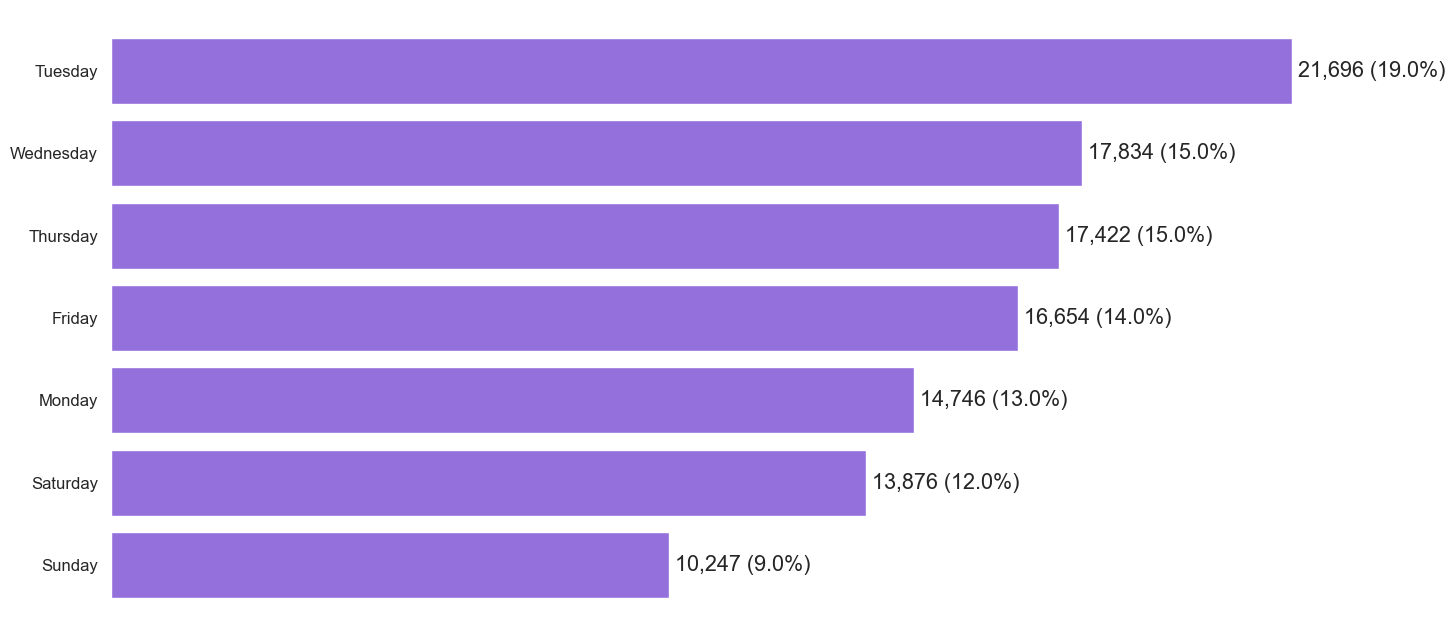

In [90]:
# визуализация количества купленных товаров в разрезе по дням недели

figure, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 8))
bars = axes.barh(range(len(products_per_weekday.products_count)), products_per_weekday.products_count, color='mediumpurple')

axes.tick_params(left=False, bottom=False, labelbottom=False)
axes.set_frame_on(False)
axes.set_yticks(range(len(products_per_weekday)))
axes.set_yticklabels(products_per_weekday.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        axes.text(
            value,
            bar.get_y() + bar.get_height()/2,
            ' {:,} ({:.1f}%)'.format(int(value),int(value*100/products_per_weekday.sum())),
            va='center',
            ha='left'
        )
        
plt.show()